In [ ]:
#hide
#colab
IN_COLAB = True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    IN_COLAB = False

!ln -s /content/drive/MyDrive/fastai_xla_extensions /content/fastai_xla_extensions

Mounted at /content/drive


In [ ]:
#default_exp core

# Core XLA extensions

> Single TPU Core Extensions

Use this module if running on a single TPU Core
as the main process.

```
from fastai_xla_extensions.core import *
```

In [ ]:
#hide
#colab
IN_COLAB = True

In [ ]:
#hide
#colab
import os
if IN_COLAB:
    assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
![ -d /content ] && [ ! -d /content/data ] && curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


In [ ]:
#hide
#colab
![ -d /content ] && pip install -Uqq fastcore --upgrade
![ -d /content ] && pip install -Uqq fastai --upgrade
![ -d /content ] && pip install -qqq nbdev --upgrade

     |████████████████████████████████| 51kB 3.1MB/s 


In [ ]:
#hide
#colab
![ -d /content ] && pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 80kB/s 
     |████████████████████████████████| 61kB 3.4MB/s 


In [ ]:
#hide
#colab
# use this for getting pytorch XLA nightly version
# VERSION = "20200707"  #@param ["1.5" , "20200325","20200707", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.2.5
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


In [ ]:
#hide
# Start of kernel

In [ ]:
#hide
#colab
%cd /content/fastai_xla_extensions

/content/drive/MyDrive/fastai_xla_extensions


In [ ]:
#hide

from nbdev.showdoc import *

In [ ]:
#exporti
from fastai_xla_extensions.utils import xla_imported

In [ ]:
#exporti
try:
    import torch_xla
except ImportError:
    pass

In [ ]:
#hide

if not xla_imported():
    from types import SimpleNamespace
    from typing import Union,BinaryIO
    import os
    import pickle
    import torch.cuda
    def fake_opt_step(opt,barrier=False):
        opt.step()
    def fake_device(n=None, devkind=None):
        gpu_available = torch.cuda.is_available()
        return torch.device(torch.cuda.current_device()) if gpu_available else torch.device('cpu')
    def fake_save(obj, f: Union[str, os.PathLike, BinaryIO], master_only=True, global_master=False): 
        return torch.save(obj,f,pickle_module=pickle, 
                          pickle_protocol=2, 
                          _use_new_zipfile_serialization=True)
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device,
        save = fake_save
    )
    

In [ ]:
#exporti
if xla_imported():
    import torch_xla.core.xla_model as xm
    
from fastcore.foundation import GetAttr, patch
from fastcore.transform import Transform,DisplayedTransform
from fastcore.basics import store_attr
from torch import Tensor
import torch
from fastai.vision.augment import AffineCoordTfm, RandomResizedCropGPU
from fastai.data.core import DataLoaders
from fastai.data.load import DataLoader
from fastai.learner import Learner
from fastai.callback.core import Callback, TrainEvalCallback
from fastai.learner import Recorder

In [ ]:
#export

class XLAOptimProxy(GetAttr):
    "Proxy optimizer to override `opt.step` with Pytorch XLA sync method `xm.optimizer_step` "
    _default='opt'
    def __init__(self,opt, barrier):
        self.opt = opt
        self._barrier = barrier

    def step(self):
        xm.optimizer_step(self.opt,barrier=self._barrier)

    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

`XLAOptimProxy` is a class which has overridden the `step` method to call the Pytorch-XLA function `xm.optimizer_step` which synchronizes the XLA graph. 

All other calls to `XLAOptimProxy` just forward it to the internal `self.opt` instance.

In [ ]:
#export
class DeviceMoverTransform(DisplayedTransform):
    "Transform to move input to new device and reverse to cpu"
    def __init__(self, device_to, device_from=torch.device('cpu')):
        store_attr('device_to,device_from')
    def encodes(self, o:Tensor):
        return o.to(self.device_to)
    def decodes(self, o:Tensor):
        return o.to(self.device_from)

`DeviceMoverTransform` is a simple transform that moves the batch input from the CPU to the XLA device. 

This is in lieu of the normal mechanism of the DataLoader implementation where the dls.device is set to the XLA device before the start of any batch transformations in the dataloaders.

Unfortunately, the AffineCoordTfm which is used for data augmentation (all the batch Zoom, Warp, Rotate augmentations) cause a problem when run on the TPU due to some affine operations not currently implemented in the Pytorch XLA) which triggers a lowering of the XLA Tensors to the CPU to perform the affine operation and causes a massive slowdown, even much slower than just doing the affine transform in the CPU in the first place.

The solution is then to postpone the moving of the input batch to TPU after the affine transformation, by setting the dls.device to None, which is done in the before_fit method of the XLAOptCallback. 


In [ ]:
#export

def isAffineCoordTfm(o:Transform):
    "check whether the transform is either an AffineCoordTfm or RandomResizedCropGPU"
    return isinstance(o,(AffineCoordTfm,RandomResizedCropGPU))

def isDeviceMoverTransform(o:Transform):
    "check whether the transform is a DeviceMoverTransform"
    return isinstance(o,DeviceMoverTransform)

def has_affinecoord_tfm(dls: DataLoaders) -> bool:
    "returns true if train dataloader has an AffineCoordTfm in the batch_tfms"
    if not hasattr(dls.train.after_batch,'fs'): return False
    idxs = dls.train.after_batch.fs.argwhere(isAffineCoordTfm)
    return len(idxs) > 0
def has_devicemover_tfm(dl: DataLoader) -> bool:
    "returns true if train dataloader has a DeviceMoverTransform in the batch_tfms"
    if not hasattr(dl.after_batch,'fs'): return False
    idxs = dl.after_batch.fs.argwhere(isDeviceMoverTransform)
    return len(idxs) > 0

def get_last_affinecoord_tfm_idx(dl:DataLoader)-> int: # -1 if none
    "returns index of last AffineCoordTfm if it exists, otherwise returns -1"
    idxs = dl.after_batch.fs.argwhere(isAffineCoordTfm)
    return -1 if len(idxs) == 0 else idxs[-1]

These functions are for the purpose of modifying the batch transforms pipeline to add a device mover transform that moves the batch input sample to the TPU since this step has been disabled (by setting the dls.device to None) so that all batch transforms prior to the device mover transform are by default executed on the CPU.

These internal functions just check the types of `Transform` in the `after_batch` pipeline.

In [ ]:
#export
def insert_batch_tfm(dl:DataLoader, batch_tfm:Transform, idx:int):
    "adds a batch_tfm in the batch_tfms for the dataloader at idx location"
    dl.after_batch.fs.insert(idx, batch_tfm)

This inserts a batch transform for a dataloader at the index location `idx`.

In [ ]:
#export
@patch
def setup_input_device_mover(self: Learner, new_device):
    "setup batch_tfms to use cpu if dataloader batch_tfms has AffineCoordTfms"
    if not has_affinecoord_tfm(self.dls):
        self.dls.device = new_device
        return
    self.dls.device = None
    if has_devicemover_tfm(self.dls.train):
        return # skip adding device mover if already added
    dm_tfm = DeviceMoverTransform(new_device)
    for dl in self.dls.loaders:
        if not has_devicemover_tfm(dl):
            idx = get_last_affinecoord_tfm_idx(dl)
            if idx != -1:
                insert_batch_tfm(dl, dm_tfm, idx+1)

In [ ]:
#hide_input
from fastai.learner import Learner
show_doc(Learner.setup_input_device_mover)

<h4 id="Learner.setup_input_device_mover" class="doc_header"><code>Learner.setup_input_device_mover</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.setup_input_device_mover</code>(**`new_device`**)

setup batch_tfms to use cpu if dataloader batch_tfms has AffineCoordTfms

This will add a device mover transform to the batch transforms if any of them trigger a lowering from the TPU to CPU. Currently identified transforms that cause this are the `AffineCoordTfm` and `RandomResizeCropGPU` transforms. 

If none of the transforms are present, the dls.device is set to XLA so that when the `TrainEvalCallback.before_fit` is called, the model is also moved to the TPU.

In [ ]:
#export

class XLAOptCallback(Callback):
    'Callback to replace `opt.step` with `xm.optimizer_step(opt)` as required to run on TPU'
    run_after,run_before = TrainEvalCallback,Recorder
    def __init__(self, barrier=True):
        self._barrier = barrier

    def before_fit(self):
        'replace opt with proxy which calls `xm.optimizer_step` instead of `opt.step` and set `dls.device` and model to `xla_device`'
        # set dls device to none so prevent trigger of moving to batch input to XLA device
        # as this move will be done by the DeviceMoverTransform which has been added to the dls after_batch tfms
        if has_affinecoord_tfm(self.dls):
            self.dls.device = None

        if self.learn.opt is not None:
            if not isinstance(self.learn.opt,XLAOptimProxy):
                # force opt to reinitialize its parameters and make sure its parameters
                opt = self.learn.opt
                self.learn.opt = XLAOptimProxy(opt, barrier=self._barrier)

    def after_fit(self):
        'restore original opt '
        if isinstance(self.learn.opt, XLAOptimProxy):
            opt = self.learn.opt.opt
            self.learn.opt = opt
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

This callback replaces the learner's `opt` with an instance of `XLAOptimProxy` that proxies the original `opt` during the beginning of the `fit` method and restores the original `opt` after the `fit`.

It also sets the `dataloaders.device` and the `learn.model` to use a TPU core using the device returned by the `xm.xla_device()` method.

In [ ]:
#export

@patch
def to_xla(self:Learner, new_device=None):
    "Setup learner for single tpu core training"
    self.add_cb(XLAOptCallback())
    if new_device is None:
        new_device = xm.xla_device()
    self.model.to(new_device)
    self.setup_input_device_mover(new_device)
    self.opt = None
    return self

`Learner.to_xla` makes sure the model and dataloader has been moved to the xla device prior to creating the optimizer by setting the opt to None which will force a call to create_opt in the fit methods after already moving the model to the TPU device in this method.

In [ ]:
#export

@patch
def detach_xla(self:Learner):
    "reset TPU single core setup and move model and dls back to cpu "
    self.remove_cb(XLAOptCallback)
    self.dls.device = torch.device('cpu')
    self.model = self.model.to(self.dls.device)
    self.opt = None
    return self

In [ ]:
#hide
# import pickle
# @patch
# def export(self:Learner, fname='export.pkl', pickle_module=pickle, pickle_protocol=2):
#     "Export the content of `self` without the items and the optimizer state for inference"
#     if rank_distrib(): return # don't export if child proc
#     self._end_cleanup()
#     old_dbunch = self.dls
#     self.dls = self.dls.new_empty()
#     state = self.opt.state_dict() if self.opt is not None else None
#     self.opt = None
#     with warnings.catch_warnings():
#         #To avoid the warning that come from PyTorch about model not being checked
#         warnings.simplefilter("ignore")
#         xm.save(self, self.path/fname)
#     self.create_opt()
#     if state is not None: self.opt.load_state_dict(state)
#     self.dls = old_dbunch


## Example: Create an MNIST classifier

> This is an example of the `fastai_xla_extensions.core` module in action.

First, we import fastai libraries. 

In [ ]:
#hide
#colab
%cd /content

/content


In [ ]:
from fastai.vision.all import *
from fastai.callback.training import GradientAccumulation


Also, import the `fastai_xla_extensions.core` package as
```
from fastai_xla_extensions.core import *
```

Load data

In [ ]:
path = untar_data(URLs.MNIST_TINY)
Path.BASE_PATH = path

Create datablock


In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=aug_transforms(do_flip=False, min_scale=0.8) # trigger usage of RandomResizedCropGPU
    # batch_tfms=[]
)

Set dataloader to load the batches to the cpu 

In [ ]:
dls = datablock.dataloaders(path)

In [ ]:
dls.device

device(type='cpu')

Note that at this point, the dataloaders is still using the CPU device.

In [ ]:
dls.train.after_batch.fs

(#4) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ]

Also, note that using the batch transforms (`batch_tfms`) adds the `Warp` (actually any zoom, warp, resize, rotate transforms which are subclasses of `AffineCoordTfm`)  and `RandomResizedCropGPU` transform which unfortunately aren't supported by XLA yet and trigger a "lowering" (i.e. move the input tensor back to CPU and perform the operation there and move it back to TPU afterwards) which causes a massive performance slowdown.

As a workaround, these batch transform operations are done first on the CPU. 

See the discussion later on the `DeviceMoverTransform` which is added if any of these transforms are present. 

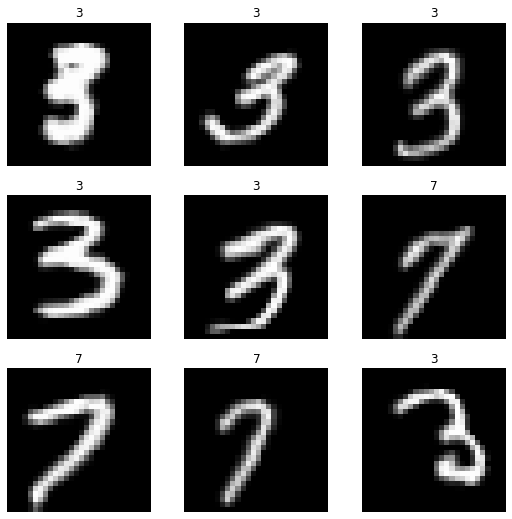

In [ ]:
dls.show_batch()

Any operations such as `show_batch` are run on the CPU and the `fastai_xla_extensions` module does not modify any base fastai functionality.

Create the Learner


In [ ]:
learner = cnn_learner(dls, resnet18, metrics=accuracy, concat_pool=False)

In [ ]:
learner.dls.train.after_batch.fs

(#5) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}:
en

Again, this shows the list of transforms as the one previously listed, with the addition of `Normalize` transform, which is added by the cnn_learner (default parameter `normalize=True`) which adds the normalization parameters from where the model was pre-trained on.

In [ ]:
#colab
learner.to_xla(xm.xla_device());

Calling the `to_xla()` method sets the `Learner` up for TPU model training. 

This includes adding the `XLAOptCallback` which enables the XLA method `xm.optimizer_step` to be called instead of the `opt.step` method as well as move the model to the TPU. 

It also either adds a `DeviceMoverTransform` to the batch transforms pipeline (which will move the input batch sample to TPU after performing any batch transforms that are `AffineCoordTfms`-based (such as zoom, warp, rotate and resize) or a `RandomResizedCropGPU` transform) or set the DataLoaders device to the TPU if no batch transforms which trigger a lowering are present in the data loading pipeline.


In [ ]:
learner.dls.device is None

True

In [ ]:
learner.dls.train.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

In [ ]:
learner.dls.valid.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

The `learner` object should have an `xla_opt` attribute which confirms that `XLAOptCallback` has been added to the list of callbacks for this learner.

In [ ]:
#colab
learner.xla_opt

XLAOptCallback

In [ ]:
#colab
learner.xla_opt.barrier

True

In [ ]:
learner.dls.device is None

True

In [ ]:
learner.opt is None

True

In [ ]:
one_param(learner.model).device

device(type='xla', index=1)

In [ ]:
#colab
has_affinecoord_tfm(learner.dls)

True

In [ ]:
#colab
has_devicemover_tfm(learner.dls.train)

True

In [ ]:
#colab
learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, XLAOptCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch 

In [ ]:
#colab
learner.opt is None

True

In [ ]:
#colab
learner.dls.device

In [ ]:
#colab
class CheckXLADeviceCallback(Callback):
    def before_fit(self):
        if self.dls.device is not None:
            print(f'dls device: {self.dls.device} model device: {one_param(self.learn.model).device}')
        else:
            print(f'dls device: None model device: {one_param(self.learn.model).device}')
        if self.learn.opt is not None:
            param = first(self.learn.opt.all_params())[0]
            print(f'opt param device: {param.device}')

    def before_epoch(self):
        if self.dls.device is not None:
            print(f'dls device: {self.dls.device} model device: {one_param(self.learn.model).device}')
        else:
            print(f'dls device: None model device: {one_param(self.learn.model).device}')

This `CheckXLADeviceCallback` will check what device is used by the dataloader and model during training.

Run `fit` to train the model.

In [ ]:
#colab
learner.fine_tune(6,freeze_epochs=4, cbs=CheckXLADeviceCallback())

dls device: None model device: xla:1
opt param device: xla:1
dls device: None model device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,1.212897,0.930756,0.517883,00:07
1,1.006261,0.491894,0.706724,00:02
2,0.862030,0.290165,0.884120,00:03
3,0.756027,0.301076,0.859800,00:02


dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
opt param device: xla:1
dls device: None model device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,0.424950,0.252019,0.898426,00:03
1,0.399239,0.196441,0.918455,00:03
2,0.337198,0.142003,0.949928,00:02
3,0.275987,0.118676,0.959943,00:03
4,0.234504,0.111183,0.959943,00:03
5,0.211221,0.098037,0.964235,00:03


dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1


In [ ]:
#colab
learner.dls.train.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

In [ ]:
#colab
learner.detach_xla()

In [ ]:
#colab
learner.dls.device is None

False

In [ ]:
#colab
learner.opt is None

True

In [ ]:
one_param(learner.model).device

device(type='cpu')

In [ ]:
#colab
learner.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learner = cnn_learner(dls,resnet18, metrics=accuracy, concat_pool=False)

In [ ]:
#colab
learner.load('stage-1')

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
#colab
learner.to_xla()

In [ ]:
learner.dls.device is None

True

In [ ]:
#colab
learner.fit_flat_cos(1,cbs=CheckXLADeviceCallback())

dls device: None model device: xla:1
opt param device: xla:1
dls device: None model device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,0.137979,0.095806,0.964235,00:03


In [ ]:
one_param(learner.model).device

device(type='xla', index=1)

In [ ]:
#colab
learner.save('stage-2')

Path('models/stage-2.pth')

In [ ]:
#colab
learner.load('stage-2')

In [ ]:
#colab
learner.fine_tune(6, freeze_epochs=4, cbs=CheckXLADeviceCallback())

dls device: None model device: xla:1
opt param device: xla:1
dls device: None model device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,0.121228,0.083677,0.974249,00:07
1,0.131540,0.111718,0.951359,00:02
2,0.120400,0.106594,0.949928,00:02
3,0.115614,0.103225,0.955651,00:02


dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
opt param device: xla:1
dls device: None model device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,0.121454,0.088395,0.958512,00:03
1,0.114384,0.067998,0.967096,00:03
2,0.096788,0.066798,0.975680,00:03
3,0.089270,0.060574,0.984263,00:03
4,0.090887,0.066932,0.981402,00:03
5,0.085645,0.076002,0.981402,00:03


dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1


In [ ]:
learner.dls.train.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

In [ ]:
#colab
learner.save('stage-4')

Path('models/stage-4.pth')

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=9.12010818865383e-07)

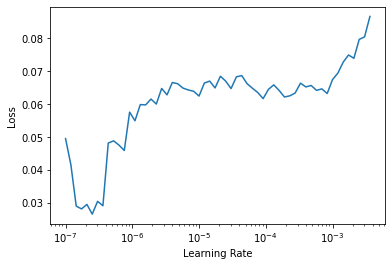

In [ ]:
#colab
learner.lr_find()

In [ ]:
#colab
learner.fit_one_cycle(5, lr_max=slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.200678,3.476557,0.789700,00:08
1,0.243603,0.631567,0.934192,00:03
2,0.285016,0.068424,0.989986,00:03
3,0.221255,0.027258,0.995708,00:03
4,0.170763,0.004546,0.997139,00:03


In [ ]:
#colab
learner.save('stage-5')

Path('models/stage-5.pth')

Gradient Accum callback (which calls CancelBatchException) should still work.

An alternative design for the XLA Opt Callback which raises the CancelBatchException in the `after_backward` method (after executing `xm.optimizer_step` and `opt.zero_grad`) would interfere with the Gradient Accum callback (which raises `CancelBatchException` in the `after_backward` method to [skip the gradient updates](https://github.com/fastai/fastai/blob/master/fastai/callback/training.py#L22) in order to accumulate the gradients).

The current design (add/remove `XLAOptimProxy` during `before_fit` and `after_fit` callback lifecycle methods) is less disruptive and more compatible with other callbacks.

In [ ]:
#colab
learner.fit_one_cycle(4,cbs=[GradientAccumulation(n_acc=2),])

epoch,train_loss,valid_loss,accuracy,time
0,0.134134,0.701767,0.773963,00:09
1,0.186499,0.135774,0.984263,00:03
2,0.185508,0.003770,0.998569,00:03
3,0.144123,0.007452,0.994278,00:03


Valid loss has kind of plateaued so this look ok.  

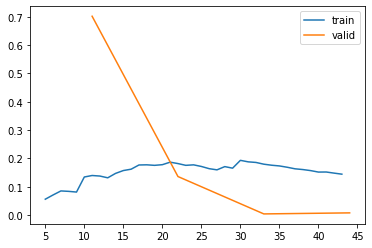

In [ ]:
#colab
learner.recorder.plot_loss()

Plot moms and lr across batches/epochs

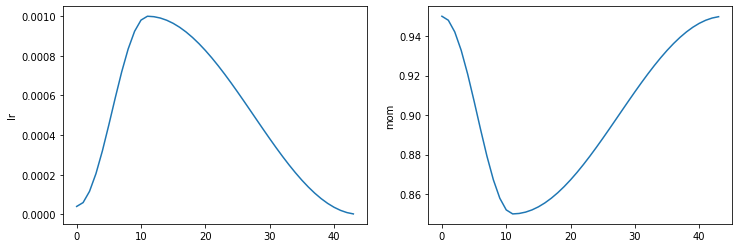

In [ ]:
#colab
learner.recorder.plot_sched()

Get Classification Interpretation for more details on model performance

In [ ]:
#colab
interp = ClassificationInterpretation.from_learner(learner)

Plot confusion matrix

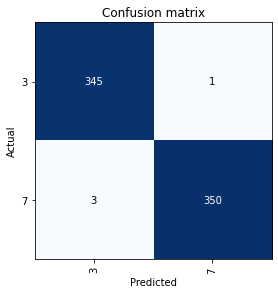

In [ ]:
#colab
interp.plot_confusion_matrix()

Samples where model was most confused

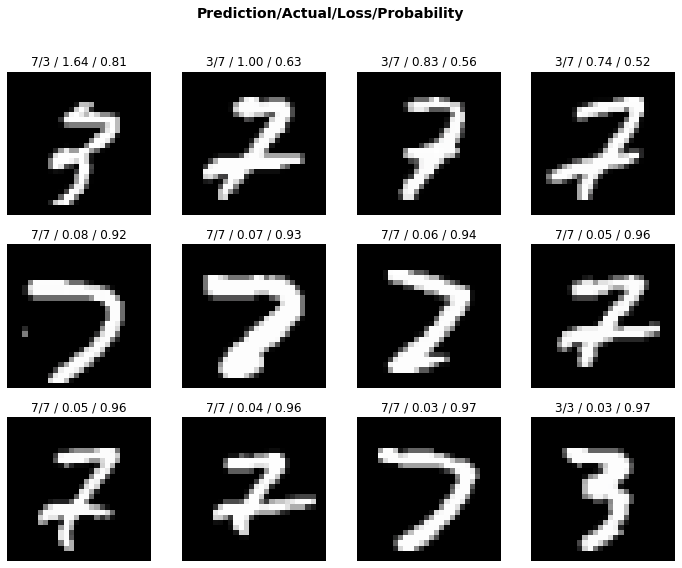

In [ ]:
#colab
interp.plot_top_losses(12)

**End of Notebook**